In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Working on new docking oracles.

In [43]:
from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
    'search_mode': 'balanced',
    'scoring': 'gnina',
    'seed': 5
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(9.5, 11.5),
    acceptable=(7.125, 9.5)
)

# Create noisy evaluator
noisy_docking_oracle = NoisyOracle(
    docking_oracle,
    sigma=0.5
)

noisy_docking_utility = ClassicUtilityFunction(
    noisy_docking_oracle,
    ideal=(8.5, 9.5),
    acceptable=(7.125, 9.5)
)

Run experiment.

In [45]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import MultiStepDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = deck[10:15].update_annotations(),
    assays = [docking_utility.oracle.reset_cache()],
    budget = 400,
    utility_function = docking_utility,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 10, 'strict': False}},
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 10, 'strict': True}},
    {'name': 'ADAM17 affinity'},
]

drug_agent = MultiStepDrugAgent(
    num_steps = 2,
    designer = designer,
    sequence = sequence,
    utility_function = noisy_docking_utility,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 1
)

experiment = Experiment(drug_agent, drug_env)

print(experiment.drug_env.assays['ADAM17 affinity'](experiment.drug_env.library)[0])
result = experiment.run(1, progress=True)

5.672063125462473


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]



  0%|                                                                                           | 0/400 [00:00<?, ?it/s]

5.672063125462473






  4%|███▎                                                                              | 16/400 [00:11<04:29,  1.43it/s]



542it [19:04,  2.11s/it]                                                               | 26/400 [00:40<10:54,  1.75s/it]
1658it [19:36,  1.41it/s]  


6.78076436331222






  9%|███████▍                                                                          | 36/400 [02:34<34:17,  5.65s/it]

6.78076436331222






 12%|█████████▍                                                                        | 46/400 [03:48<37:00,  6.27s/it]

6.78076436331222


  0%|                                                                                             | 0/1 [04:15<?, ?it/s]


KeyboardInterrupt: 

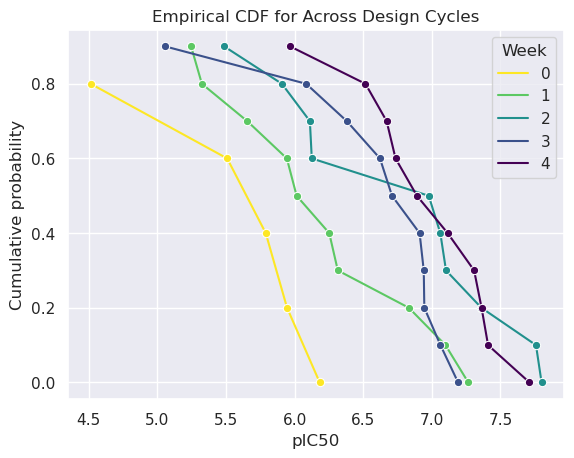

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

scores = experiment.drug_agent.utility_function.oracle(experiment.drug_env.library)
design_cycles = experiment.drug_env.library.annotations['timestep'].fillna(0).astype(int)

df = pd.DataFrame({'score': scores, 'cycle': design_cycles})

# Ensure the DataFrame is sorted by time_step, then score
df = df.sort_values(by=['cycle', 'score'])

# Calculate the empirical CDF for each time step
df['cdf'] = (
    1 -
    df
    .groupby('cycle')['score']
    .transform(lambda x: np.arange(1, len(x) + 1) / len(x))
)

# Plot
g = sns.lineplot(
    data=df,
    x='score',
    y='cdf',
    hue='cycle',
    marker='o',
    palette='viridis_r'
)

plt.xlabel('pIC50')
plt.ylabel('Cumulative probability')
plt.title(f'Empirical CDF for Across Design Cycles')
g.legend(title='Week')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


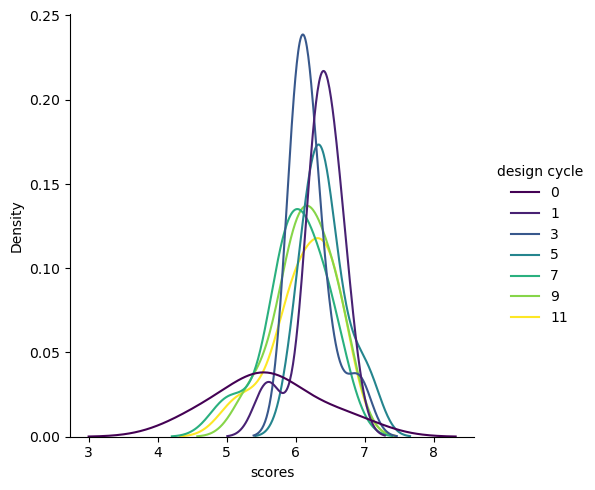

In [51]:
import seaborn as sns
import pandas as pd

scores = experiment.drug_agent.utility_function.oracle(experiment.drug_env.library)
design_cycles = experiment.drug_env.library.annotations['timestep'].fillna(0).astype(int)

sns.displot(
    data = pd.DataFrame({'scores': scores, 'design cycle': design_cycles}),
    x = 'scores',
    hue = 'design cycle',
    palette='viridis',
    kind='kde'
)

In [41]:
import pandas as pd
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

results = []
sigmas = [0.0, 1e-1, 2e-1]

for sigma in tqdm(sigmas):
    
    noisy_docking_utility.oracle.sigma = sigma
    
    drug_env = DrugEnv(
        designer,
        library = dg.MoleculeCollection([best_molecules[-80]]).update_annotations(),
        assays = [docking_oracle],
        budget = 80,
        utility_function = docking_utility,
    )

    drug_agent = SequentialDrugAgent(
        sequence = sequence,
        utility_function = noisy_docking_utility,
        exploration_strategy = EpsilonGreedy(epsilon = 0.0),
        branch_factor = 2
    )

    experiment = Experiment(drug_agent, drug_env)
    result = experiment.run(2, sigma=sigma)
    results.extend(result)

df = pd.DataFrame(results)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

5.6168341108962645
5.6168341108962645
5.6168341108962645
6.1340211808450125
6.1340211808450125
6.1340211808450125
6.446015649866715
6.446015649866715
6.446015649866715


KeyboardInterrupt: 

In [39]:
import pandas as pd

def ecdf(costs):
    costs_sorted = np.sort(costs)
    probs = 1. * np.arange(1, len(costs) + 1) / len(costs)

    costs_sorted = [0.0, *costs_sorted]
    probs = [0.0, *probs]
    
    return costs_sorted, probs

data = pd.DataFrame()
noises = sigmas
for noise in noises:
    raw_costs = [r['cost'] for r in df.to_dict('records') if r['sigma'] == noise]
    cost, prob = ecdf(raw_costs)
    temp = pd.DataFrame({'cost': cost, 'prob': prob, 'noise': noise})
    data = pd.concat([data, temp])

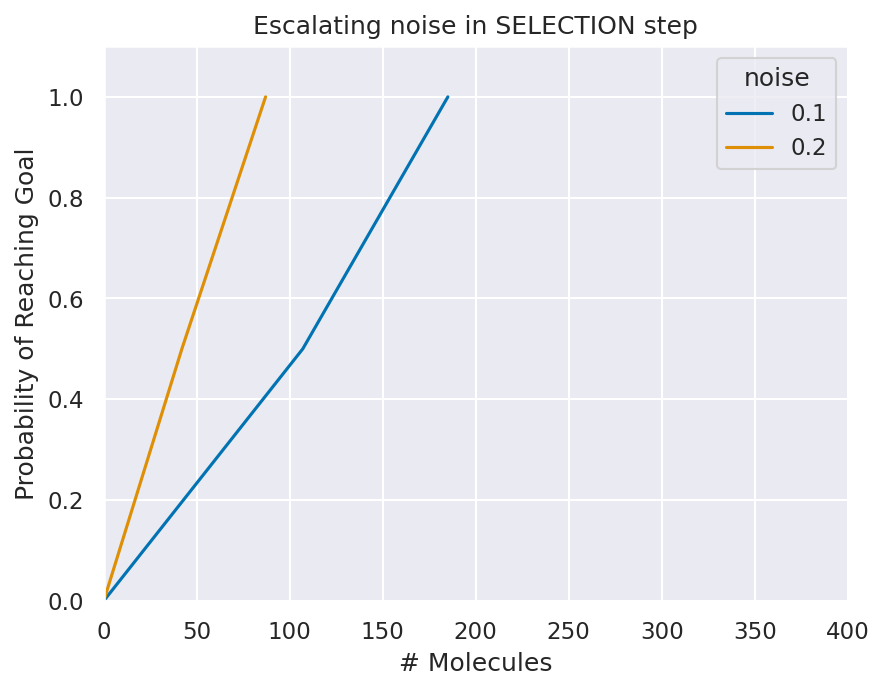

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
g = sns.lineplot(
    data,
    x='cost',
    y='prob',
    hue='noise',
    palette='colorblind',
)

g.set_title('Escalating noise in SELECTION step')
g.set_xlabel('# Molecules')
g.set_ylabel('Probability of Reaching Goal')
g.set_ylim([0, 1.1])
g.set_xlim(0, 400)

plt.gcf().set_dpi(150)
plt.show()